## Projeto de Redes Sociais

In [116]:
import freeman as fm
import pandas as pd
import seaborn as sns
from unidecode import unidecode
import math
import random
import statsmodels.api as sm
import networkx as nx
import pylab
import numpy as np
import statistics


In [113]:
# https://www.kaggle.com/jeanmidev/crossfit-games
# athletes = pd.read_csv('data/crossfit/2019_opens_athletes.csv')

C:\Users\lchen\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning:

Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.



In [4]:
# scores = pd.read_csv('data/crossfit/2019_opens_scores.csv')

In [5]:
# athletes = athletes.dropna(subset=['affiliateid', 'affiliatename', 'overallrank'])
# men = athletes[athletes['divisionid'] == 1]
# gyms = {}
# for _, row in men.iterrows():
#     if (row['affiliateid'] in gyms.keys()):
#         if (gyms[row['affiliateid']][0] != row['affiliatename']):
#             print('Duplicate', gyms[row['affiliateid']], row['affiliatename'])
#     gyms[row['affiliateid']] = [row['affiliatename']]

In [6]:
# for key, value in gyms.items():
#     gyms[key].append(men[men['affiliateid'] == key]['overallscore'].mean())

In [70]:

# gyms = {k: v for k, v in sorted(gyms.items(), key=lambda item: item[1][1])}

# gyms_list = list(gyms.values())
# # gyms_list = [0, 1, 2, 3]
# if (len(gyms_list) % 2 == 0):
#     median = (gyms_list[int(len(gyms_list) / 2)][1] + gyms_list[int(len(gyms_list) / 2) - 1][1]) / 2
# else:
#     median = gyms_list[math.floor(len(gyms_list) / 2)][1]
# print(median)

In [69]:
# gyms_list = list(gyms.items())
# print(len(gyms_list))

# for _ in range(int(len(gyms_list) / 1.1)):
#     rand_int = random.randint(0, len(gyms_list) - 1)
#     gyms_list.pop(rand_int)
# print(len(gyms_list))


In [68]:
# filename = 'data/gyms.gml'
# with open(filename, 'w') as f:
#     tmp = 'graph [\n  directed 0\n'

#     for affiliateid, value in gyms_list:
#         tmp += '  node [\n    id ' + str(affiliateid) + '\n    affiliate_name "' + unidecode(value[0]) + '"\n  ]\n'

#     f.write(tmp)
#     i = 0
#     for affiliateid, value in gyms_list:
#         percentage = round(i/len(gyms.items())*100, 2)
#         if (percentage % 1 == 0):
#             print('Progress: {}%'.format(percentage, ), end = '\r')
#         for affiliate2id, value2 in gyms_list[gyms_list.index((affiliateid, value)) + 1:]:
# #             if ((affiliateid != affiliate2id) and (((value[1] + value2[1]) / 2) > median) ):
#             if ((affiliateid != affiliate2id) and ((value[1] > median) and (value2[1] > median))):
#                 f.write('  edge [\n    source ' + str(affiliateid) +'\n    target ' + str(affiliate2id) +'\n  ]\n')
#         i += 1

#     f.write(']')
#     print('Progress: {}%'.format(100.0))
#     print('Done')



In [108]:
# g = fm.load('data/gyms.gml')

In [1]:
# g.set_all_nodes(size=10, labpos='hover')

# # Deixar as arestas semi-transparentes para
# # a visualização ficar um pouco mais leve.
# g.set_all_edges(color=(0, 0, 0, 0.25))

# # Usar um algoritmo especial para posicionar
# # os nós de acordo com grupos.
# g.move('kamada_kawai')

# g.draw()

In [110]:
# gym_scores = [x[1][1] for x in gyms_list]
# gyms_closeness = []
# for gym in gyms_list:
#     for n in g.nodes:
#         if n == gym[0]:
#             gyms_closeness.append(nx.closeness_centrality(g, n))

In [67]:

# ax = pylab.subplot(111)
# ax.scatter(gyms_closeness, gym_scores)
# pylab.xlabel('Closeness')
# pylab.ylabel('Gym performance')
# pylab.suptitle('Closeness x Performance', fontsize=16)
# ax.figure.show()

In [66]:
# model = sm.OLS(gym_scores, gyms_closeness)
# result = model.fit()
# result.summary()

In [29]:
schools = pd.read_csv('data/chicago-public-schools-progress-report-cards-2011-2012-1.csv')

In [92]:
print(len(es)/1.3)

343.8461538461538


In [85]:
# schools.info()

In [95]:
es = schools[schools['Elementary, Middle, or High School'] == 'ES']
es = es.dropna(subset=['ISAT Value Add Math'])
# print(es['ISAT Value Add Math'].values.tolist())
# es.describe()

# Remove n rows
drop_indices = np.random.choice(es.index, int(len(es)/1.3), replace=False)
es = es.drop(drop_indices)

In [96]:

# https://stackoverflow.com/a/56769419/9785530

def Haversine(lat1,lon1,lat2,lon2, **kwarg):
    """
    This uses the ‘haversine’ formula to calculate the great-circle distance between two points – that is, 
    the shortest distance over the earth’s surface – giving an ‘as-the-crow-flies’ distance between the points 
    (ignoring any hills they fly over, of course!).
    Haversine
    formula:    a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
    c = 2 ⋅ atan2( √a, √(1−a) )
    d = R ⋅ c
    where   φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
    note that angles need to be in radians to pass to trig functions!
    """
    R = 6371.0088
    lat1,lon1,lat2,lon2 = map(np.radians, [lat1,lon1,lat2,lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) **2
    c = 2 * np.arctan2(a**0.5, (1-a)**0.5)
    d = R * c
    return round(d,4)

In [97]:
Haversine(41.653674, -87.841052, 42.021064, -87.533007)

48.1679

In [98]:
distances = []
for i in range(len(es)):
#     percentage = round(i/len(es)*100, 2)
    print('{}/{}'.format(i, len(es)), end='\r')
#     if (percentage % 0.5 == 0):
#         print('Progress: {}%'.format(percentage, ), end = '\r')
    for j in range(i+1, len(es)):
        school1 = es.iloc[i]
        school2 = es.iloc[j]
        distances.append(Haversine(school1['Latitude'], school1['Longitude'], school2['Latitude'], school2['Longitude']))
print('Done')


Done104


In [134]:
filename = 'data/schools.gml'
median = np.median(distances)/2
# stdev = statistics.stdev(distances)/2
with open(filename, 'w') as f:
    tmp = 'graph [\n  directed 0\n'

    for i in range(len(es)):
        tmp += '  node [\n    id ' + str(es.iloc[i]['School ID']) + '\n    isatm "' + str(es.iloc[i]['ISAT Value Add Math']) + '"\n  ]\n'

    f.write(tmp)
    for i in range(len(es)):
        print('{}/{}'.format(i, len(es)), end='\r')
        for j in range(i+1, len(es)):
            if (Haversine(es.iloc[i]['Latitude'], es.iloc[i]['Longitude'], es.iloc[j]['Latitude'], es.iloc[j]['Longitude']) < median):
                f.write('  edge [\n    source ' + str(es.iloc[i]['School ID']) +'\n    target ' + str(es.iloc[j]['School ID']) +'\n  ]\n')

    f.write(']')
#     print('Progress: {}%'.format(100.0))
    print('Done')

Done104


In [135]:
g = fm.load('data/schools.gml')

In [136]:
g.set_all_nodes(size=10, labpos='hover')

# Deixar as arestas semi-transparentes para
# a visualização ficar um pouco mais leve.
# g.set_all_edges(color=(0, 0, 0, 0.25))

# Usar um algoritmo especial para posicionar
# os nós de acordo com grupos.
g.move('kamada_kawai')

g.draw()

In [137]:
school_scores = []
for i in range(len(es)):
    school_scores.append(es.iloc[i]['ISAT Value Add Math'])
school_closeness = []
for n in g.nodes:
    school_closeness.append(nx.closeness_centrality(g, n))

<ipython-input-138-8f9cfc4dae0b>:6: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



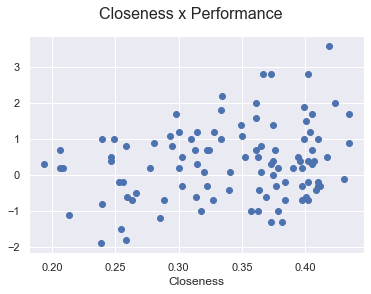

In [138]:
ax = pylab.subplot(111)
ax.scatter(school_closeness, school_scores)
pylab.xlabel('Closeness')
pylab.ylabel('')
pylab.suptitle('Closeness x Performance', fontsize=16)
ax.figure.show()

In [139]:
model = sm.OLS(school_scores, school_closeness)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.129
Model:                            OLS   Adj. R-squared (uncentered):              0.121
Method:                 Least Squares   F-statistic:                              15.26
Date:                Fri, 30 Oct 2020   Prob (F-statistic):                    0.000168
Time:                        19:58:43   Log-Likelihood:                         -149.25
No. Observations:                 104   AIC:                                      300.5
Df Residuals:                     103   BIC:                                      303.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1287      0.289      3.907      0.000       0.556       1.702
==============================================================================
Omnibus:                        3.758   Durbin-Watson:                   2.235
Prob(Omnibus):                  0.153   Jarque-Bera (JB):                3.221
Skew:                           0.419   Prob(JB):                        0.200
Kurtosis:                       3.206   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""